In [1]:
import random
import magnum as mn
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import habitat_sim
import habitat_sim.nav as nav
from habitat.utils.visualizations import maps
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut
from habitat_sim.utils.common import quat_from_angle_axis, quat_to_angle_axis
from habitat_sim.utils.common import d3_40_colors_rgb


PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring


In [2]:
# Dataset and scene
dataset_config_file = "../ai2thor-hab-dataset/ai2thor-hab/ai2thor-hab.scene_dataset_config.json"
scene = "FloorPlan19_physics"

# Sensors and other sim settings
rgb_sensor = True  # @param {type:"boolean"}
depth_sensor = True  # @param {type:"boolean"}
semantic_sensor = False  # @param {type:"boolean"}

In [3]:
# Define the simulator configuration
sim_settings = {
    "dataset": dataset_config_file,  # Scene dataset
    "scene": scene,  # Scene path
    "width": 512,  # Spatial resolution of the observations
    "height": 512,
    "default_agent": 0,
    "sensor_height": 1.5,  # Height of sensors in meters
    "color_sensor": rgb_sensor,  # RGB sensor
    "depth_sensor": depth_sensor,  # Depth sensor
    "semantic_sensor": semantic_sensor,  # Semantic sensor
    "seed": 1,
    "enable_physics": False,  # kinematics only
}

In [4]:
# Function to display the sensor data
def display_sample(rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])):
    # Visualize the observations
    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")

    arr = [rgb_img]
    titles = ["rgb"]
    if semantic_obs.size != 0:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(18, 12))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)

In [5]:
# Function to create the simulator configuration
def make_cfg(settings):
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.gpu_device_id = 0
    sim_cfg.scene_dataset_config_file = settings["dataset"]
    sim_cfg.scene_id = settings["scene"]
    sim_cfg.enable_physics = settings["enable_physics"]
    sim_cfg.create_renderer = False

    # Note: all sensors must have the same resolution
    sensors = {
        "color_sensor": {
            "sensor_type": habitat_sim.SensorType.COLOR,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
        },
        "depth_sensor": {
            "sensor_type": habitat_sim.SensorType.DEPTH,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
        },
        "semantic_sensor": {
            "sensor_type": habitat_sim.SensorType.SEMANTIC,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
        },
    }

    sensor_specs = []
    for sensor_uuid, sensor_params in sensors.items():
        if settings[sensor_uuid]:
            sensor_spec = habitat_sim.CameraSensorSpec()
            sensor_spec.uuid = sensor_uuid
            sensor_spec.sensor_type = sensor_params["sensor_type"]
            sensor_spec.resolution = sensor_params["resolution"]
            sensor_spec.position = sensor_params["position"]
            sensor_specs.append(sensor_spec)

    # Here you can specify the amount of displacement in a forward action and the turn angle
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    agent_cfg.sensor_specifications = sensor_specs
    agent_cfg.action_space = {
        "move_forward": habitat_sim.agent.ActionSpec(
            "move_forward", habitat_sim.agent.ActuationSpec(amount=0.25)
        ),
        "turn_left": habitat_sim.agent.ActionSpec(
            "turn_left", habitat_sim.agent.ActuationSpec(amount=30.0)
        ),
        "turn_right": habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=30.0)
        ),
    }

    return habitat_sim.Configuration(sim_cfg, [agent_cfg])

In [7]:
# Initialize the simulator
try:  
    sim.close()
except NameError:
    pass
cfg = make_cfg(sim_settings)
sim = habitat_sim.Simulator(cfg)

In [8]:
# Define navmesh settings
navmesh_settings = habitat_sim.NavMeshSettings()
navmesh_settings.agent_height = 1.5
navmesh_settings.agent_radius = 0.1
navmesh_settings.agent_max_climb = 0.2
navmesh_settings.agent_max_slope = 45.0
navmesh_settings.include_static_objects = True  # Include static objects in the navmesh computation

# Recompute the navmesh for the current scene
success = sim.recompute_navmesh(sim.pathfinder, navmesh_settings)

# Recompute the navmesh for the current scene
success = sim.recompute_navmesh(sim.pathfinder, navmesh_settings)
if not sim.pathfinder.is_loaded:
    print("Pathfinder not initialized, aborting.")
else:
    # @markdown NavMesh area and bounding box can be queried via *navigable_area* and *get_bounds* respectively.
    print("NavMesh area = " + str(sim.pathfinder.navigable_area))
    print("Bounds = " + str(sim.pathfinder.get_bounds()))

NavMesh area = 21.721248626708984
Bounds = (Vector(-0.232217, -0.121493, -4.38955), Vector(3.7819, 2.55251, 0.414728))


In [9]:
# Initialize an agent
agent = sim.initialize_agent(sim_settings["default_agent"])
agent_state = habitat_sim.AgentState()
random_position = sim.pathfinder.get_random_navigable_point()
agent_state.position = np.array([random_position[0], 0.0, random_position[2]])
agent_state.rotation = np.quaternion(1.0, 0.0, 0.0, 0.0)
agent.set_state(agent_state)

In [22]:
import habitat.utils.visualizations.maps as maps
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R

def plot_agent_on_map(sim, agent):
    # Generate top-down map directly from the simulator
    topdown_map = maps.get_topdown_map_from_sim(sim)
    map_image = maps.colorize_topdown_map(topdown_map)

    # Get agent state
    agent_state = agent.get_state()
    agent_position = agent_state.position
    agent_rotation = agent_state.rotation  # This is a quaternion

    # Convert quaternion to yaw angle in degrees
    r = R.from_quat([agent_rotation.x, agent_rotation.y, agent_rotation.z, agent_rotation.w])
    agent_heading = r.as_euler('xyz', degrees=True)[1]  # Extract the yaw component

    # Convert agent's 3D position to 2D top-down coordinates
    map_agent_pos = maps.to_grid(
        agent_position[0], agent_position[2],  # Convert 3D position to 2D
        topdown_map.shape, 
        pathfinder=sim.pathfinder
    )

    # Plot map and agent position
    plt.figure(figsize=(10, 10))
    plt.imshow(map_image)
    # Draw agent's position and heading
    maps.draw_agent(map_image, map_agent_pos, agent_heading)
    plt.axis("off")
    plt.title("Agent Position on Top-Down Map")
    plt.show()


agent_state: position [ 0.7177834   0.07850688 -3.3452365 ] rotation quaternion(0.499999850988388, 0, 0.866025507450104, 0)
action move_forward


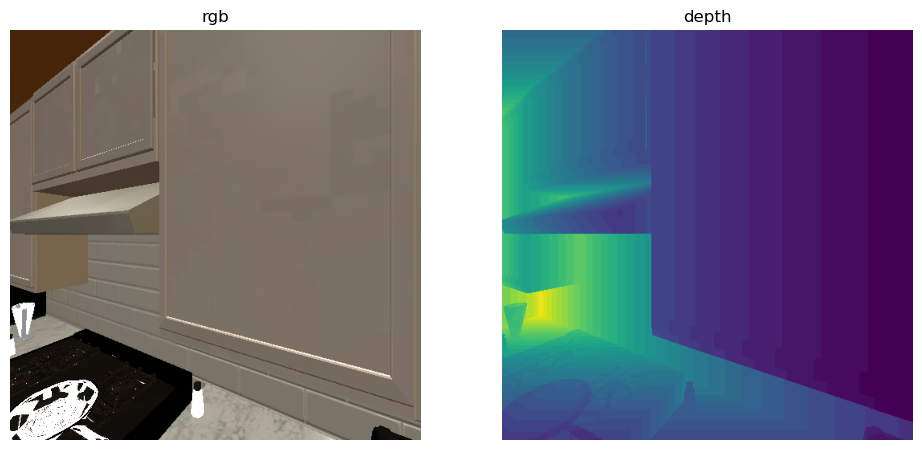

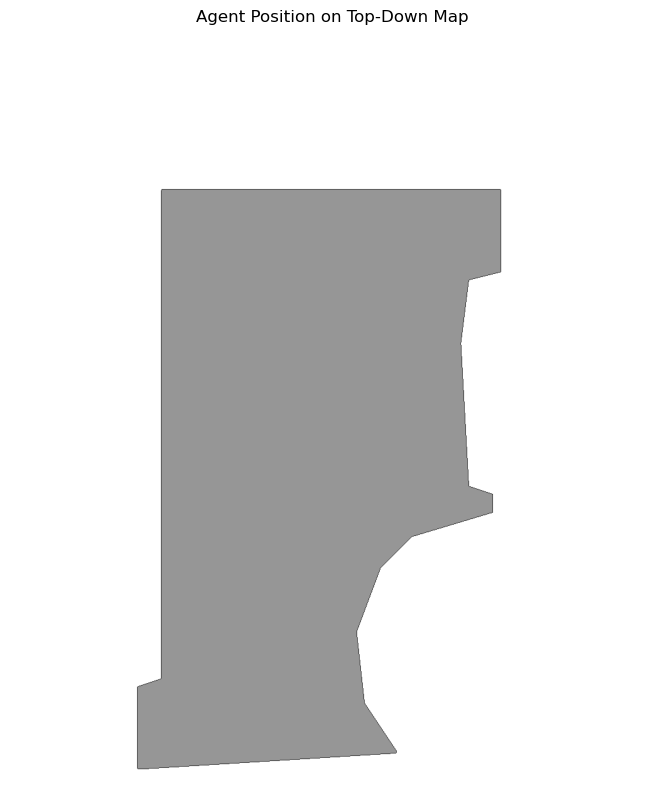

agent_state: position [ 0.7177834   0.07850688 -3.2202365 ] rotation quaternion(0.499999850988388, 0, 0.866025507450104, 0)
action turn_left


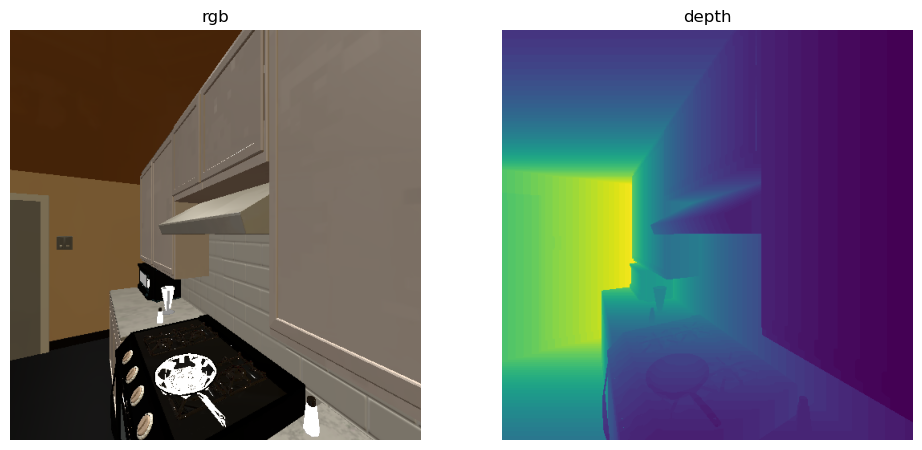

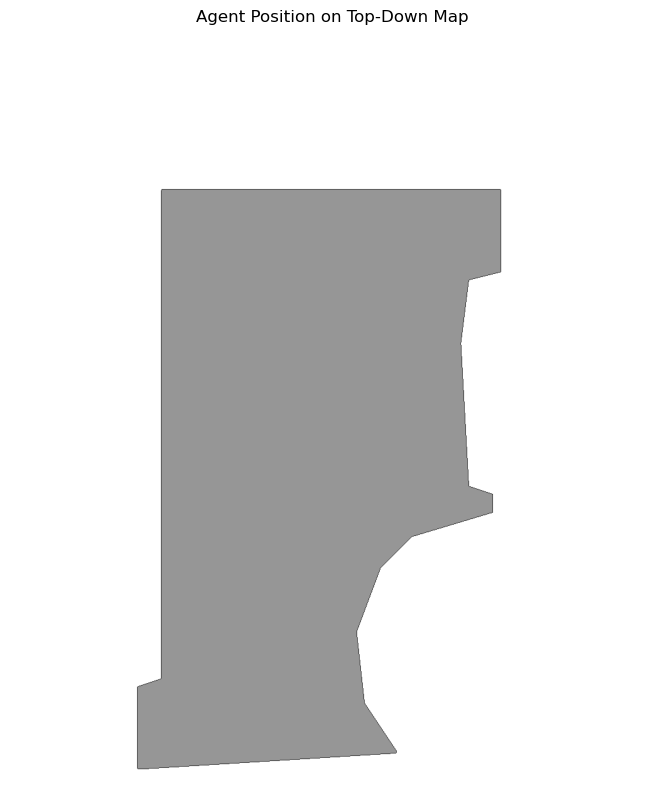

agent_state: position [ 0.7177834   0.07850688 -3.2202365 ] rotation quaternion(0.258818864822388, 0, 0.965925872325897, 0)
action turn_left


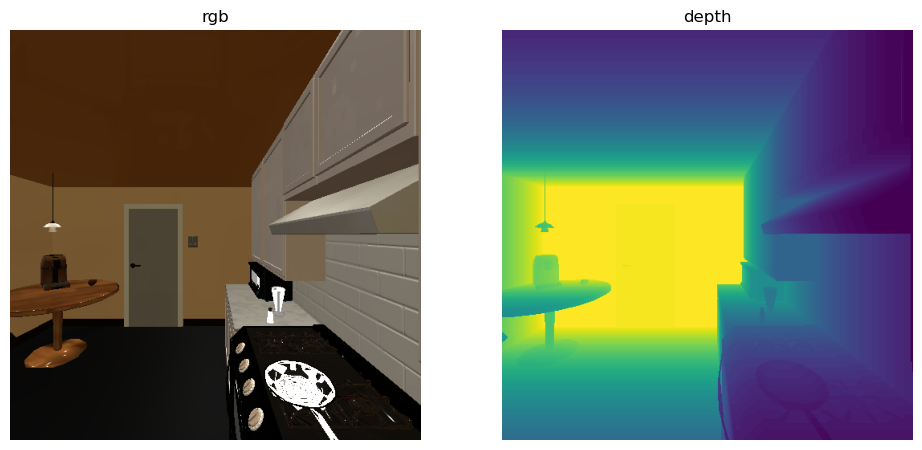

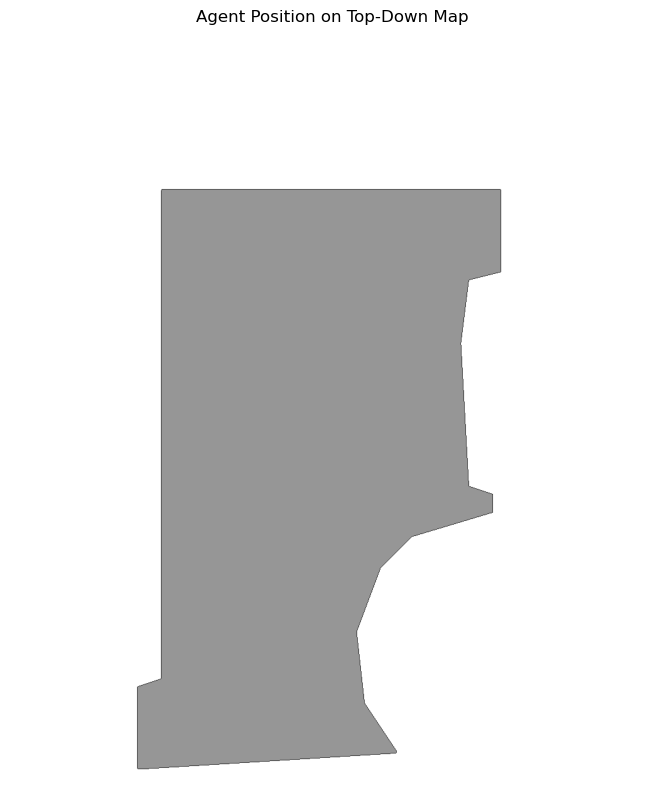

agent_state: position [ 0.7177834   0.07850688 -3.2202365 ] rotation quaternion(-1.78813934326172e-07, 0, 1, 0)
action turn_right


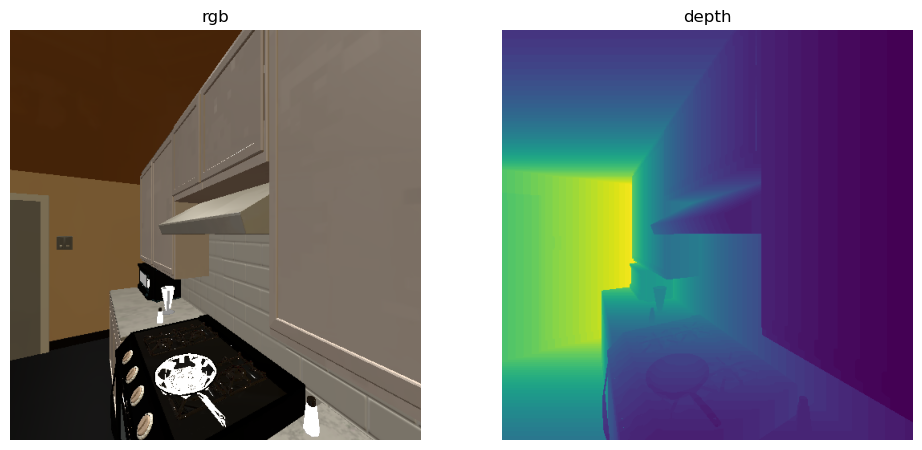

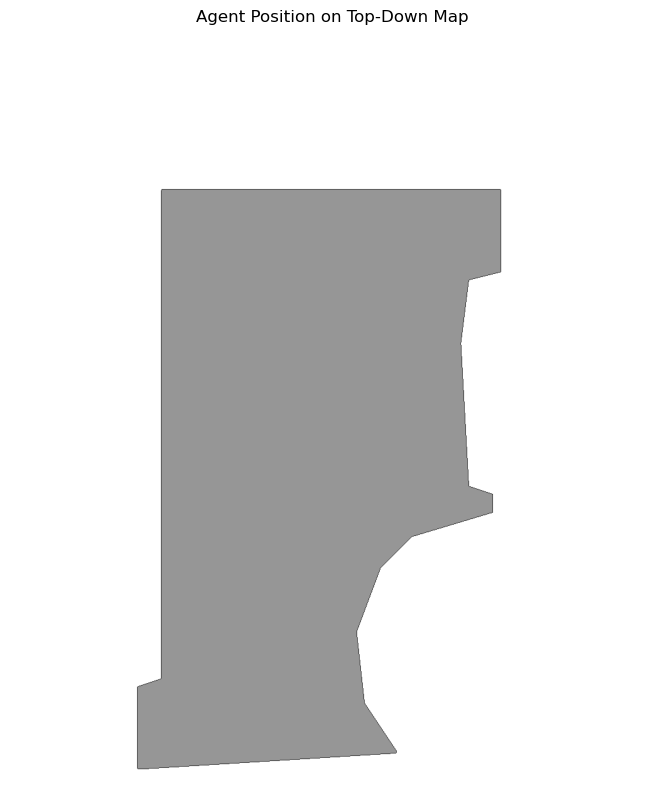

agent_state: position [ 0.7177834   0.07850688 -3.2202365 ] rotation quaternion(0.258818864822388, 0, 0.965925872325897, 0)
action turn_right


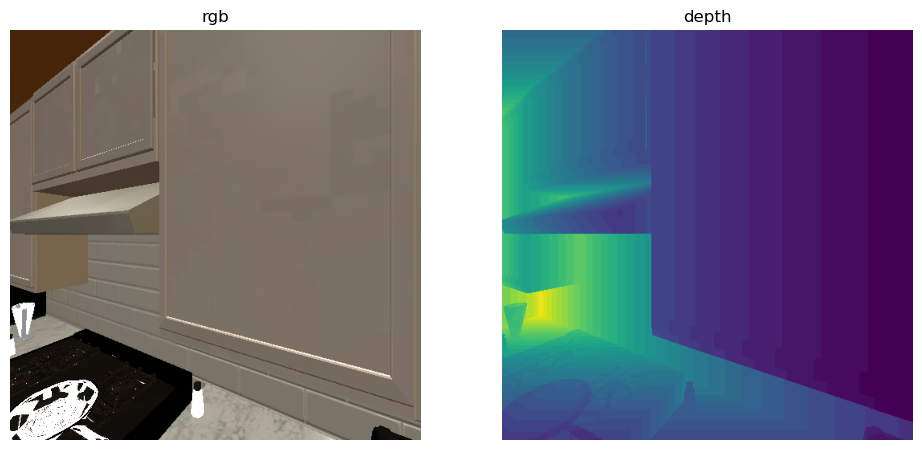

: 

In [23]:
total_frames = 0
action_names = list(cfg.agents[sim_settings["default_agent"]].action_space.keys())
max_frames = 10

while total_frames < max_frames:

    # Get agent state
    agent_state = agent.get_state()
    print("agent_state: position", agent_state.position, "rotation", agent_state.rotation)

    # Take an action and get the observations
    action = random.choice(action_names)
    print("action", action)
    observations = sim.step(action)
    rgb = observations["color_sensor"]
    depth = observations["depth_sensor"]
    display_sample(rgb, np.array([]), depth)

    plot_agent_on_map(sim, agent)

    total_frames += 1